Model 1: Logistic Regression

In [1]:
!pip install gensim --quiet

In [2]:
!pip install tensorflow-datasets --quiet

In [3]:
!pip install -U tensorflow-text --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 44.1 MB/s eta 0:00:00


In [4]:
!pip install pydot --quiet

**Step 1: importing necessary libraries
**

In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#for text pre-pricessing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline


#bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#for word embedding
import gensim
from gensim.models import Word2Vec

#google collab drive read data
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda, Dropout
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds
import tensorflow_text as tf_text
from transformers import BertTokenizer, TFBertModel
from transformers import logging
logging.set_verbosity_error()
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping




import sklearn as sk
import os
import nltk
from nltk.data import find

import matplotlib.pyplot as plt

import re


import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.test.utils import datapath

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


***Step 2: Load the dataset. In the "Reddit and Sarcasm" study, we inquire whether a sentence contains sarcasm or irony. If there is no sarcasm, it is labeled as 0; if sarcasm is present, it is labeled as 1.




In [6]:
def plot_model_performance(model_history, model_name='Model'):
    metrics = ['loss', 'accuracy']
    plt.figure(figsize=(10, 5))

    for i, metric in enumerate(metrics):
        plt.subplot(1, 2, i+1)
        plt.plot(model_history.history[metric], label='Train ' + metric)
        plt.plot(model_history.history['val_' + metric], label='Val ' + metric)
        plt.title('%s - %s' % (metric, model_name))
        plt.ylabel(metric)
        plt.xlabel('Epoch')
        plt.legend()

    plt.tight_layout()
    plt.show()


In [7]:
def load_data(path):
  """
    Loads training and testing data from CSV files located at the given path.

    Args:
    path (str): The file path to the directory containing the data files.

    Returns:
    tuple: A tuple containing two pandas DataFrames, the first for training data and the second for testing data.
  """
  train_file = path + 'train.csv'
  test_file = path + 'test.csv'
  train_df = pd.read_csv(train_file)
  test_df = pd.read_csv(test_file)
  return train_df, test_df

path = '/content/drive/MyDrive/UCB-MIDS/Data_Science_Interview/algorithms/text/text_classification/data/'
train_df, test_df = load_data(path)

#Display the data
print("Train data", train_df.head())
print("Test data", test_df.head())


Train data    Y                                               text
0  1  thirtysomething scientists unveil doomsday clo...
1  0  dem rep totally nails why congress is falling ...
2  0   eat your veggies 9 deliciously different recipes
3  1  inclement weather prevents liar from getting t...
4  1  mother comes pretty close to using word stream...
Test data    Y                                               text
0  1  man wondering if there might be some sort of w...
1  0  white house official reportedly said mass shoo...
2  0  sarah palin calls obama lazy over approach to ...
3  0               eu court issues landmark data ruling
4  0  atlantic city casino can regulate waitresses w...


In [8]:
print(train_df.shape)
print(test_df.shape)

(20033, 2)
(8586, 2)


Exploratory Data Analysis
1. Class Distribution

0    10479
1     9554
Name: Y, dtype: int64


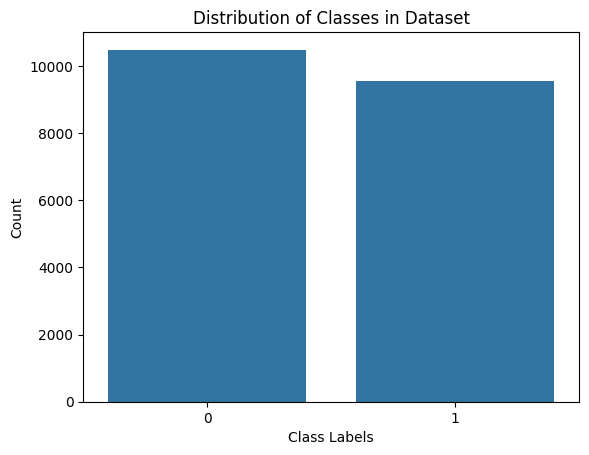

In [9]:
# Assuming x contains the value counts of 'Y' column
x = train_df['Y'].value_counts()
print(x)

# Corrected barplot call
sns.barplot(x=x.index, y=x)

# Adding a title to the bar plot
plt.xlabel('Class Labels')  # Set x-axis label
plt.ylabel('Count')         # Set y-axis label
plt.title('Distribution of Classes in Dataset')

# Show the plot with the title
plt.show()


From the above plot, it is seen that the dataset is relatively balanced with 10479 instances in class 0 and 9554 instances in class 1. Hence, we wouldn't be applying SMOTE/undersampling techniques here  

2. Missing Values

In [10]:
#missing values
train_df.isna().sum()

Y       0
text    0
dtype: int64

 3. Number of words in sarcasm from redit

In [11]:
#word count
train_df['word_count'] = train_df['text'].apply(lambda x: len(str(x).split()))
print("Class 1 mean word count: ", train_df[train_df['Y']==1]['word_count'].mean())


train_df['word_count'] = train_df['text'].apply(lambda x: len(str(x).split()))
print("Class 0 mean word count: ", train_df[train_df['Y']==0]['word_count'].mean())



Class 1 mean word count:  10.515804898471844
Class 0 mean word count:  9.767153354327704


The average number of words when the text is sarcasm is 10.51
The average number of words when the text is non-sarcasm is 9.76


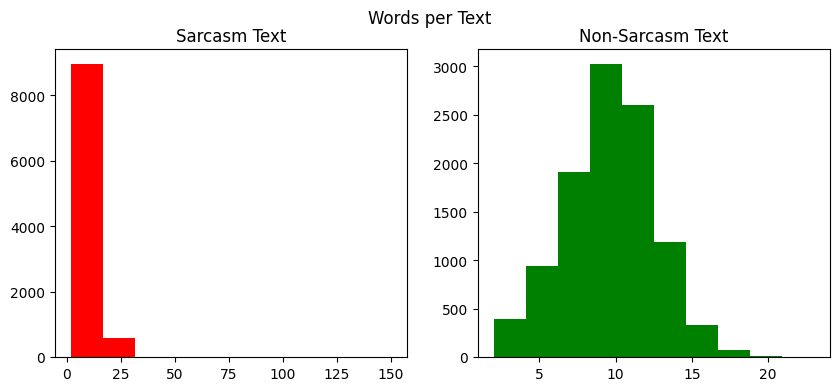

In [12]:
#plot of word count
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
train_words=train_df[train_df['Y']==1]['word_count']
ax1.hist(train_words,color='red')
ax1.set_title('Sarcasm Text')

train_words=train_df[train_df['Y']==0]['word_count']
ax2.hist(train_words,color='green')
ax2.set_title('Non-Sarcasm Text')
fig.suptitle('Words per Text')
plt.show()


The sarcasm text is right skewed and non sarcasm text is approximately normal.
 1. Brevity in Sarcasm: Sarcasm might be more effectively conveyed in shorter sentences, which can be more direct and impactful.

 2. Nature of Dataset: The dataset you're analyzing might contain sarcastic texts that are typically short, such as tweets or headlines, which are often concise by nature.

 3. This suggests that the length of the text could be an important feature for a machine learning model designed to distinguish between sarcastic and non-sarcastic texts.

4. Number of characters in text


In [13]:
train_df['char_count'] = train_df['text'].apply(lambda x: len(str(x)))
print("Sarcasm text",train_df[train_df['Y']==1]['char_count'].mean())
print("Non-Sarcasm Text",train_df[train_df['Y']==0]['char_count'].mean())


Sarcasm text 64.37063010257484
Non-Sarcasm Text 57.94083404905048


3. Split the train_df into train and val_df to avoid data leakagage. We will incorporate startified random sampling technique to ensure that the proportions of sarcasm and non-sarcasm are the same.

In [14]:
from sklearn.model_selection import train_test_split

def split_data(df, test_size=0.2, random_state=42):
    """
    Splits the DataFrame into training and validation sets in a stratified manner.

    Args:
    df (DataFrame): The DataFrame to split.
    test_size (float): The proportion of the dataset to include in the validation set.
    random_state (int): The seed used by the random number generator.

    Returns:
    tuple: A tuple containing two DataFrames, the first for the training set and the second for the validation set.
    """
    # Assuming 'target' is the column name for the target variable. Replace 'target' with the actual name.
    train_df, val_df = train_test_split(df, test_size=test_size, random_state=random_state, stratify=df['Y'])
    return train_df, val_df

# Use the function to split your train_df
train_df, val_df = split_data(train_df)

# Display the data
print("Training Set:", train_df.head())
print("Validation Set:", val_df.head())


Training Set:        Y                                               text  word_count  \
10014  1  sick parent offers man perfect excuse to move ...          14   
16351  0            22 animals wearing pajamas just because           6   
11461  0  down the rabbit hole tale of suicide and macaroni           9   
2197   0  kerry washington compares fashion to fine art ...          10   
7232   0  books with badass female protagonists what you...          10   

       char_count  
10014          74  
16351          39  
11461          49  
2197           61  
7232           59  
Validation Set:        Y                                               text  word_count  \
2319   0  ho ho no 5 reasons there no santa in our chris...          11   
273    0  meryl streep looks exactly like the shrek fair...          12   
280    0  donald trump vows to take travel ban to the su...          11   
8224   1  study all american problems could be solved by...          15   
10055  1          leaf t

In [15]:
#convert to lowercase, strip and remove punctuations
def preprocess(text):
    text = text.lower()
    text=text.strip()
    text=re.compile('<.*?>').sub('', text)
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub(r'\[[0-9]*\]',' ',text)
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text)
    text = re.sub(r'\s+',' ',text)
    return text


# STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)
#LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()

'''
This funuction is needed to convert the pos_tag into wordnet pos tag
'''
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)]
    return " ".join(a)

#final pre-processing
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))

train_df['clean_text'] = train_df['text'].apply(lambda x: finalpreprocess(x))
train_df.head()

val_df['clean_text'] = val_df['text'].apply(lambda x: finalpreprocess(x))
val_df.head()

,Y,text,word_count,char_count,clean_text
2319,0,ho ho no 5 reasons there no santa in our chris...,11,50,ho ho reason santa christmas
273,0,meryl streep looks exactly like the shrek fair...,12,71,meryl streep look exactly like shrek fairy god...
280,0,donald trump vows to take travel ban to the su...,11,57,donald trump vow take travel ban supreme court
8224,1,study all american problems could be solved by...,15,89,study american problem could solve stop think ...
10055,1,leaf that came out too early cold as shit,9,41,leaf come early cold shit


In [16]:
print("Train: target class distribtion", train_df['Y'].value_counts())
print("Validation: target class distribution", val_df['Y'].value_counts())


Train: target class distribtion 0    8383
1    7643
Name: Y, dtype: int64
Validation: target class distribution 0    2096
1    1911
Name: Y, dtype: int64


In [17]:
#Adding text_length to the train dataset as a feature
train_df['text_length'] = train_df['clean_text'].apply(len)
train_df.head()

,Y,text,word_count,char_count,clean_text,text_length
10014,1,sick parent offers man perfect excuse to move ...,14,74,sick parent offer man perfect excuse move back...,62
16351,0,22 animals wearing pajamas just because,6,39,animal wear pajama,18
11461,0,down the rabbit hole tale of suicide and macaroni,9,49,rabbit hole tale suicide macaroni,33
2197,0,kerry washington compares fashion to fine art ...,10,61,kerry washington compare fashion fine art mari...,54
7232,0,books with badass female protagonists what you...,10,59,book badass female protagonist go book,38


In [18]:
#Adding text_length to the train dataset as a feature on the validation dataset
val_df['text_length'] = val_df['clean_text'].apply(len)
val_df.head()

,Y,text,word_count,char_count,clean_text,text_length
2319,0,ho ho no 5 reasons there no santa in our chris...,11,50,ho ho reason santa christmas,28
273,0,meryl streep looks exactly like the shrek fair...,12,71,meryl streep look exactly like shrek fairy god...,58
280,0,donald trump vows to take travel ban to the su...,11,57,donald trump vow take travel ban supreme court,46
8224,1,study all american problems could be solved by...,15,89,study american problem could solve stop think ...,56
10055,1,leaf that came out too early cold as shit,9,41,leaf come early cold shit,25


In [19]:
nltk.download('word2vec_sample')

[nltk_data] Downloading package word2vec_sample to /root/nltk_data...
[nltk_data]   Unzipping models/word2vec_sample.zip.


True

In [20]:
word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))

In [21]:
vec_model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_sample, binary=False)

In [ ]:
# Set the embedding dimension
EMBEDDING_DIM = len(vec_model['university'])  # we know... it's 300


In [22]:
#Build embedded matrix

def build_embedding_matrix_and_vocab_dict(vec_model):
    # Set the embedding dimension
    EMBEDDING_DIM = len(vec_model['university'])

    # Initialize embedding matrix and word-to-id map
    embedding_matrix = np.zeros((len(vec_model) + 1, EMBEDDING_DIM))
    vocab_dict = {}

    # Build the embedding matrix and the word-to-id map
    for i, word in enumerate(vec_model.index_to_key):
        embedding_vector = vec_model[word]
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            vocab_dict[word] = i

    # Use the last index for unknown tokens
    vocab_dict['[UNK]'] = len(vocab_dict)

    return embedding_matrix, vocab_dict

# Usage
embedding_matrix, vocab_dict = build_embedding_matrix_and_vocab_dict(vec_model)


In [23]:
print(embedding_matrix.shape)

(43982, 300)


In [24]:
embedding_matrix[:5, :5]

array([[ 0.0891758 ,  0.121832  , -0.0671959 ,  0.0477279 , -0.013659  ],
       [ 0.0526281 ,  0.013157  , -0.010104  ,  0.0540819 ,  0.0386715 ],
       [ 0.0786419 ,  0.0373911 , -0.0131472 ,  0.0347375 ,  0.0288273 ],
       [-0.00157585, -0.0564239 ,  0.00320281,  0.0422498 ,  0.15264399],
       [ 0.0356899 , -0.00367283, -0.065534  ,  0.0213832 ,  0.00788408]])

In [25]:
def tokenize_dataframe(df, text_column_name, label_column_name, length_column_name):
    """
    Tokenizes the text data in the specified column of a DataFrame.

    Parameters:
    df (pandas.DataFrame): The DataFrame containing the text data.
    text_column_name (str): The name of the column containing the text to tokenize.
    label_column_name (str): The name of the column containing the labels.

    Returns:
    tuple: A tuple containing the tokenized text data and the labels.
    """
    # Extract text and label columns
    texts = df[text_column_name].values
    lengths = df[length_column_name].values
    labels = df[label_column_name].values

    # Create a tokenizer instance
    tokenizer = tf_text.WhitespaceTokenizer()

    # Convert the text array to a Tensor
    texts_tensor = tf.convert_to_tensor(texts, dtype=tf.string)
    lengths_tensor = tf.convert_to_tensor(lengths, dtype=tf.int32)


    # Tokenize the text
    tokenized_texts = tokenizer.tokenize(texts_tensor)

    return tokenized_texts, lengths_tensor, labels

train_tokens, train_lengths, train_labels = tokenize_dataframe(train_df, 'clean_text', 'Y', 'text_length')
val_tokens, val_lengths, val_labels = tokenize_dataframe(val_df, 'clean_text', 'Y', 'text_length')

In [26]:
train_tokens[0]

<tf.Tensor: shape=(11,), dtype=string, numpy=
array([b'sick', b'parent', b'offer', b'man', b'perfect', b'excuse',
       b'move', b'back', b'home', b'give', b'dream'], dtype=object)>

Data Preparation

In [27]:
MAX_SEQUENCE_LENGTH = 128

Word2Vec Model: Word2Vec is a popular word embedding technique developed by Google. It represents each word in a corpus with a vector in a high-dimensional space (e.g., 300 dimensions). Words with similar meanings have vectors close to each other in this space, capturing their semantic relationships.

Vocabulary and Indices: When a Word2Vec model is trained, it creates a vocabulary of words it has seen during training. Each word in this vocabulary is assigned a unique index or ID. For example, in a Word2Vec model, the word "apple" might be assigned an index of 157, "orange" an index of 321, and so on.

In this function, docs_to_vocab_ids, we are mapping each word in the tokenized text to its corresponding index value in the word2Vec vocabulary ('vocab_dict')

This process involves:

Converting each word to its index as per the Word2Vec model.
Using a special index for unknown words ([UNK]) that are not in the Word2Vec vocabulary.


Purpose of Index Values: These index values are crucial for neural networks and other machine learning models that work with numerical data. By converting words into indices, we effectively translate textual data into a numerical form that can be fed into these models.

Key in Word2Vec: The "key" in the Word2Vec context refers to the actual word in the vocabulary. Each key (word) is associated with a unique vector (its embedding) and an index in the model's internal representation.

In [28]:
def docs_to_vocab_ids(tokenized_texts_list):
    """
    converting a list of strings to a list of lists of word ids
    """
    texts_vocab_ids = []
    for i, token_list in enumerate(tokenized_texts_list):

        # Get the vocab id for each token in this doc ([UNK] if not in vocab)
        vocab_ids = []
        for token in list(token_list.numpy()):
            decoded = token.decode('utf-8', errors='ignore')
            if decoded in vocab_dict:
                vocab_ids.append(vocab_dict[decoded])
            else:
                vocab_ids.append(vocab_dict['[UNK]'])

        # Truncate text to max length, add padding up to max length
        vocab_ids = vocab_ids[:MAX_SEQUENCE_LENGTH]
        n_padding = (MAX_SEQUENCE_LENGTH - len(vocab_ids))
        # For simplicity in this model, we'll just pad with uknown tokens
        vocab_ids += [vocab_dict['[UNK]']] * n_padding

        # Add this example to the list of converted docs
        texts_vocab_ids.append(vocab_ids)

        if i % 5000 == 0:
            print('Examples processed: ', i)

    print('Total examples: ', i)

    return np.array(texts_vocab_ids)

In [30]:
train_input = docs_to_vocab_ids(train_tokens)
val_input = docs_to_vocab_ids(val_tokens)

train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

Examples processed:  0
Examples processed:  5000
Examples processed:  10000
Examples processed:  15000
Total examples:  16025
Examples processed:  0
Total examples:  4006


In [ ]:
#check the train input words and their numerical values for the first two
#represents the numerical values (indices) associated with the words in the first two examples
#of the training data, as mapped by the Word2Vec model's vocabulary.

train_input[:2]

array([[43812, 39475, 33581, 37990,  2259, 26130, 30379, 22560,  5341,
        16558, 26183, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
      

In [31]:
#check the numerical values for the first 4 examples in target

train_labels[:4]

array([1, 0, 0, 0])

Modeling

Averaging Network (AN) Model: We will follow the below steps:
1. We will define the embedding layer.
2. we'll average the embeddings and pass them into our classification layer.

In [39]:
def create_dan_model(retrain_embeddings=False,
                     max_sequence_length=MAX_SEQUENCE_LENGTH,
                     hidden_dim=100,
                     dropout=0.3,
                     embedding_initializer='word2vec',
                     learning_rate=0.001,
                     additional_feature_dim=1):
  """
  Construct the DAN model including the compilation and return it. Parametrize it using the arguments.
  :param retrain_embeddings: boolean, indicating whether  the word embeddings are trainable
  :param hidden_dim: dimension of the hidden layer
  :param dropout: dropout applied to the hidden layer

  :returns: the compiled model
  """

  if embedding_initializer == 'word2vec':
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix)
  else:
    embeddings_initializer='uniform'


  ### YOUR CODE HERE

  # start by creating the dan_embedding_layer. Use the embeddings_initializer. variable defined above.
  dan_input_layer = Input(shape=(max_sequence_length,), dtype='int64')
  dan_embedding_layer = Embedding(embedding_matrix.shape[0],
                                    embedding_matrix.shape[1],
                                    embeddings_initializer=embeddings_initializer,
                                    input_length=max_sequence_length,
                                    trainable=retrain_embeddings)(dan_input_layer)

  #Averaging embeddings
  dan_avg_embeddings = Lambda(lambda x: K.mean(x, axis=1))(dan_embedding_layer)

  # Input for the additional feature (e.g., text length)
  length_input_layer = Input(shape=(additional_feature_dim,), dtype='float32')

  # Combine the averaged embeddings with the additional feature
  combined_features = concatenate([dan_avg_embeddings, length_input_layer])

  # Hidden layer uses combined features
  hidden_layer = Dense(hidden_dim, activation='relu')(combined_features)
  hidden_layer = Dropout(dropout)(hidden_layer)

  # Output layer
  dan_classification = Dense(1, activation='sigmoid')(hidden_layer)

  # Create the model with two inputs
  dan_model = Model(inputs=[dan_input_layer, length_input_layer], outputs=dan_classification)

  # Compile the model
  dan_model.compile(loss='binary_crossentropy',
                      optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                      metrics=['accuracy'])

  return dan_model

In [42]:
dan_model_shuffled = create_dan_model()


# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

dan_shuffled_history = dan_model_shuffled.fit(
    [train_input, train_lengths], train_labels,
    epochs=50,
    batch_size=32,
    shuffle=True,
    validation_data=([val_input, val_lengths], val_labels),
    callbacks=[early_stopping]
)

Epoch 1/50
501/501 [==============================] - 3s 4ms/step - loss: 0.8128 - accuracy: 0.5242 - val_loss: 0.6783 - val_accuracy: 0.5603
Epoch 2/50
501/501 [==============================] - 2s 4ms/step - loss: 0.6821 - accuracy: 0.5600 - val_loss: 0.6787 - val_accuracy: 0.5423
Epoch 3/50
501/501 [==============================] - 2s 4ms/step - loss: 0.6726 - accuracy: 0.5789 - val_loss: 0.6652 - val_accuracy: 0.5775
Epoch 4/50
501/501 [==============================] - 3s 6ms/step - loss: 0.6667 - accuracy: 0.5870 - val_loss: 0.6619 - val_accuracy: 0.5740
Epoch 5/50
501/501 [==============================] - 2s 4ms/step - loss: 0.6645 - accuracy: 0.5919 - val_loss: 0.6573 - val_accuracy: 0.6149
Epoch 6/50
501/501 [==============================] - 2s 4ms/step - loss: 0.6614 - accuracy: 0.5963 - val_loss: 0.6577 - val_accuracy: 0.6262
Epoch 7/50
501/501 [==============================] - 2s 4ms/step - loss: 0.6570 - accuracy: 0.6030 - val_loss: 0.6460 - val_accuracy: 0.6262
Epoch 

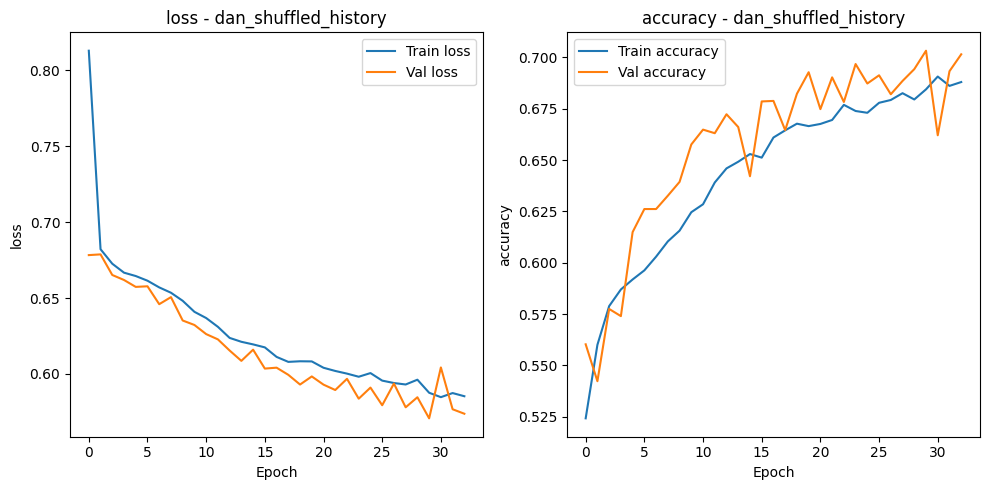

In [43]:
plot_model_performance(dan_shuffled_history, model_name='dan_shuffled_history')


In [44]:
def make_binary_predictions(model, train_inputs, val_inputs, threshold=0.5):
    """
    Make predictions with a model that requires two inputs and convert them to binary using a specified threshold.

    Parameters:
    model: The trained model used for making predictions.
    train_inputs: A tuple containing the input data for the training set, including text data and text lengths.
    val_inputs: A tuple containing the input data for the validation set, including text data and text lengths.
    threshold (float): The threshold for converting predictions to binary. Default is 0.5.

    Returns:
    tuple: A tuple containing binary predictions for the training and validation sets.
    """
    # Make predictions on the training and validation sets
    # Note: We unpack the tuples directly into the model's predict function
    train_predictions = model.predict([train_inputs[0], train_inputs[1]])
    val_predictions = model.predict([val_inputs[0], val_inputs[1]])

    # Convert predictions to binary (0 or 1) using the specified threshold
    train_predictions_binary = (train_predictions > threshold).astype(int).flatten()
    val_predictions_binary = (val_predictions > threshold).astype(int).flatten()

    return train_predictions_binary, val_predictions_binary

# Example usage
train_predictions_binary, val_predictions_binary = make_binary_predictions(
    dan_model_shuffled,
    (train_input, train_lengths),
    (val_input, val_lengths)
)


126/126 [==============================] - 0s 2ms/step


In [45]:
# Calculate and print the classification report for the training set
train_classification_report = classification_report(train_labels, train_predictions_binary, target_names=['Class 0', 'Class 1'])
print("Training Set Classification Report:\n", train_classification_report)

# Calculate and print the classification report for the validation set
val_classification_report = classification_report(val_labels, val_predictions_binary, target_names=['Class 0', 'Class 1'])
print("Validation Set Classification Report:\n", val_classification_report)


Training Set Classification Report:
               precision    recall  f1-score   support

     Class 0       0.70      0.75      0.73      8383
     Class 1       0.71      0.64      0.67      7643

    accuracy                           0.70     16026
   macro avg       0.70      0.70      0.70     16026
weighted avg       0.70      0.70      0.70     16026

Validation Set Classification Report:
               precision    recall  f1-score   support

     Class 0       0.70      0.76      0.73      2096
     Class 1       0.71      0.64      0.67      1911

    accuracy                           0.70      4007
   macro avg       0.70      0.70      0.70      4007
weighted avg       0.70      0.70      0.70      4007



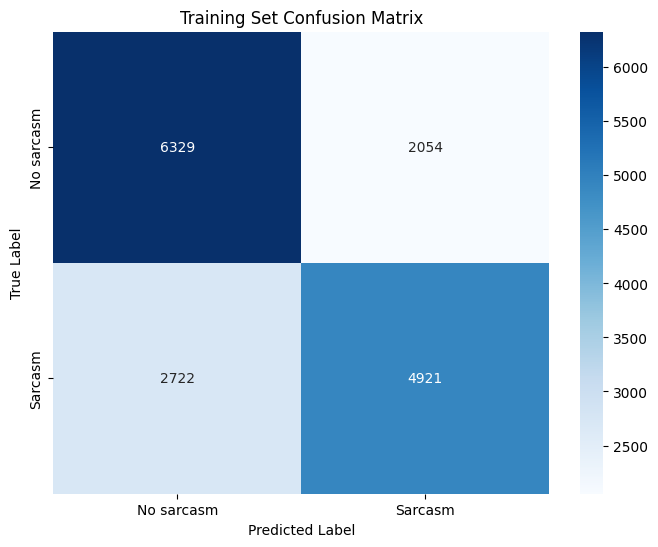

In [46]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(true_labels, predicted_labels, title='Confusion Matrix'):
    """
    Plots a confusion matrix using Seaborn's heatmap.

    Parameters:
    true_labels: Array of true labels.
    predicted_labels: Array of predicted labels.
    title (str): Title of the plot.
    """
    # Calculate the confusion matrix
    matrix = confusion_matrix(true_labels, predicted_labels)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No sarcasm', 'Sarcasm'], yticklabels=['No sarcasm', 'Sarcasm'])
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


# Plot the confusion matrix for the training set
plot_confusion_matrix(train_labels, train_predictions_binary, title='Training Set Confusion Matrix')



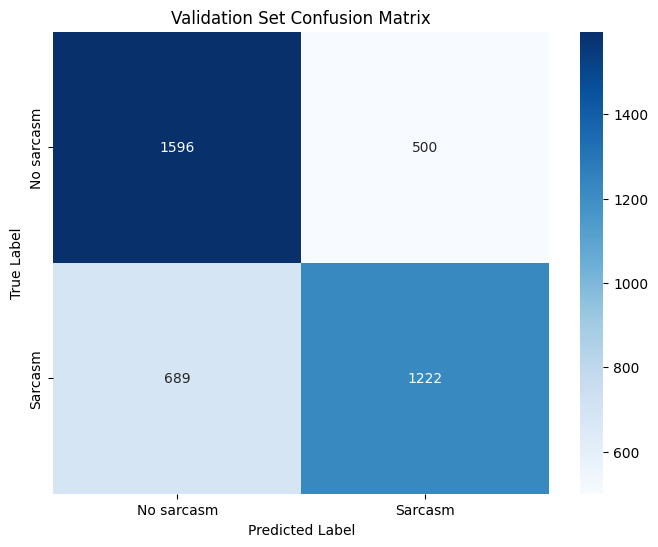

In [47]:
# Plot the confusion matrix for the validation set
plot_confusion_matrix(val_labels, val_predictions_binary, title='Validation Set Confusion Matrix')


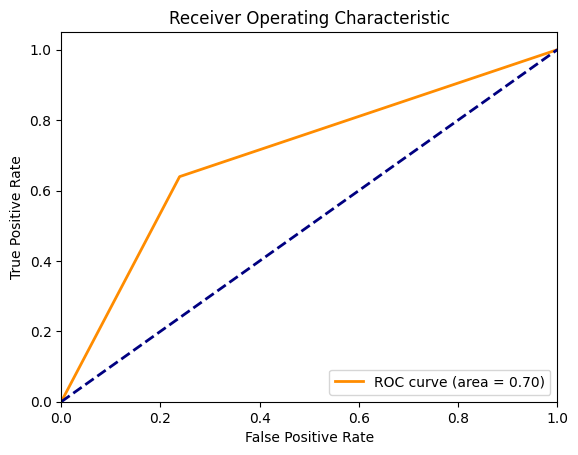

In [48]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming y_val is your validation target and y_prob_val are the predicted probabilities
fpr, tpr, thresholds = roc_curve(val_labels, val_predictions_binary)
roc_auc = auc(fpr, tpr)

# Plotting
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
